## Prepare the environment

In [2]:
!pip install fastai -q --upgrade

In [3]:
!pip install kaggle -q

## Get the data and verify it

In [4]:
import os

In [8]:
if not os.path.exists('./kaggle.json'):
  print('Please copy ./kaggle.json in your notebooks directory')

In [10]:
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! rm kaggle.json

In [11]:
from kaggle.api.kaggle_api_extended import KaggleApi
from fastai.vision.all import *

In [12]:
api = KaggleApi()
api.authenticate()

In [13]:
dataset_path = './datasets/starwars/'

In [14]:
if not os.path.exists(dataset_path):
    api.dataset_download_files(dataset='mathurinache/star-wars-images', unzip=True, path=dataset_path)

In [15]:
failed = verify_images(get_image_files(dataset_path))
failed.map(Path.unlink)
len(failed)

0

## Create and train the model

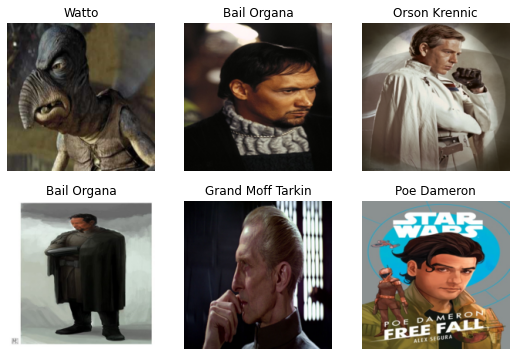

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(dataset_path, bs=32)

dls.show_batch(max_n=6)

In [17]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.959116,1.296440,0.329101,00:47


epoch,train_loss,valid_loss,error_rate,time
0,1.162849,0.854594,0.216931,00:45
1,0.533858,0.637379,0.154497,00:47
2,0.212089,0.607916,0.138624,00:46


## Check the results of the trained model

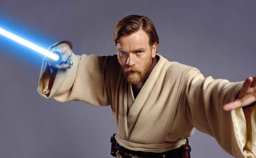

In [18]:
dest = './datasets/starwars/Obi-Wan/image_20211118_161838_478.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [19]:
character_name, character_id, probs = learn.predict(PILImage.create(dest))
print(f"This is: {character_name}.")
print(f"Probability it's {character_name}: {probs[character_id]:.4f}")

This is: Kenobi.
Probability it's Kenobi: 0.7035


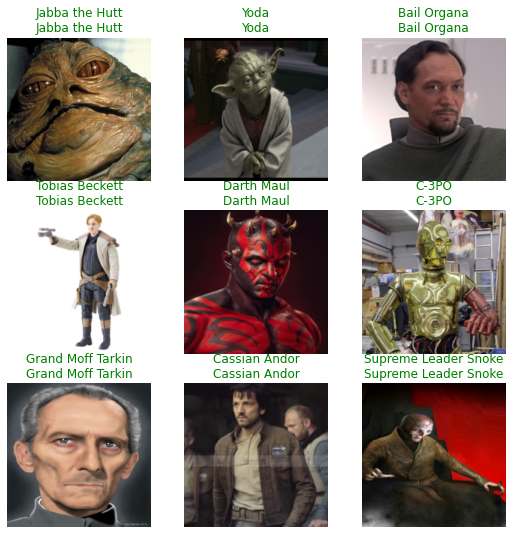

In [20]:
learn.show_results()

In [21]:
learn.export(fname='./star_wars_model_01.pkl', pickle_module=pickle, pickle_protocol=2)

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

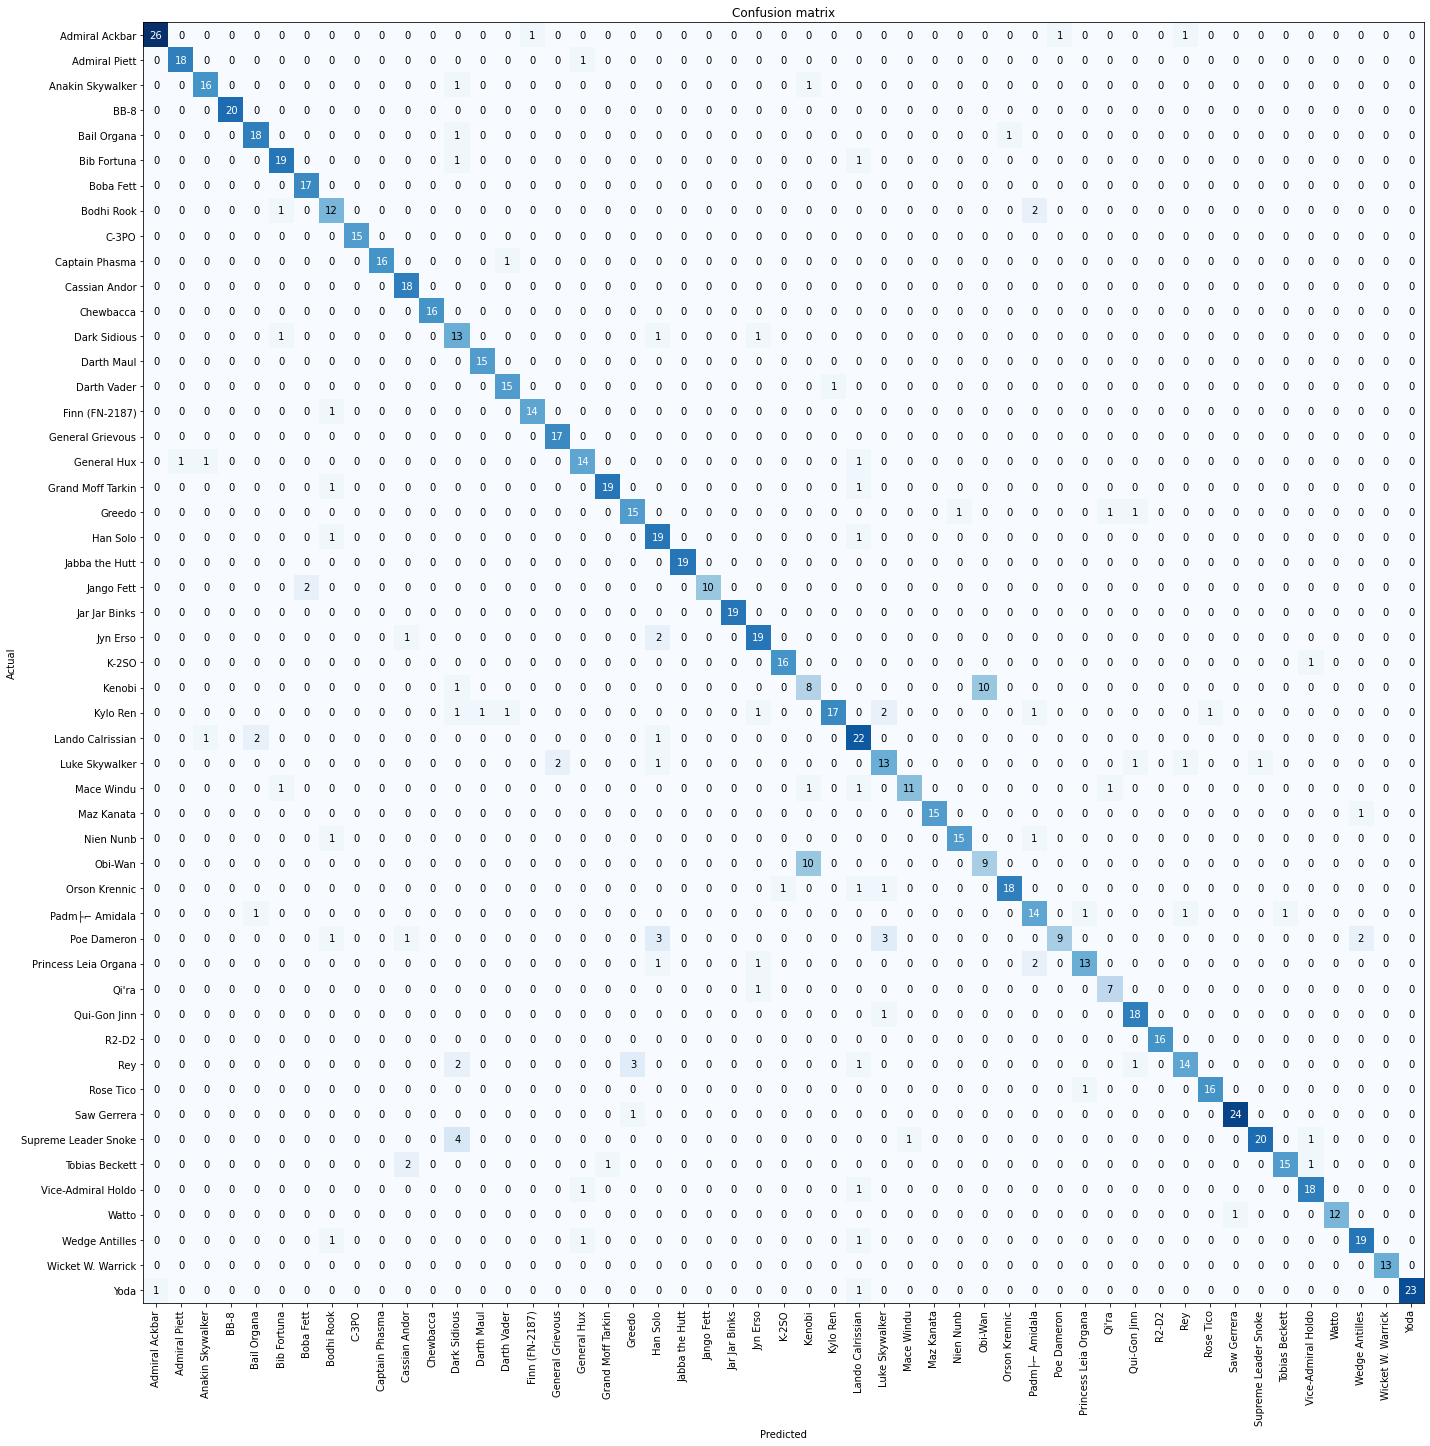

In [24]:
interp.plot_confusion_matrix(figsize=(20,20))

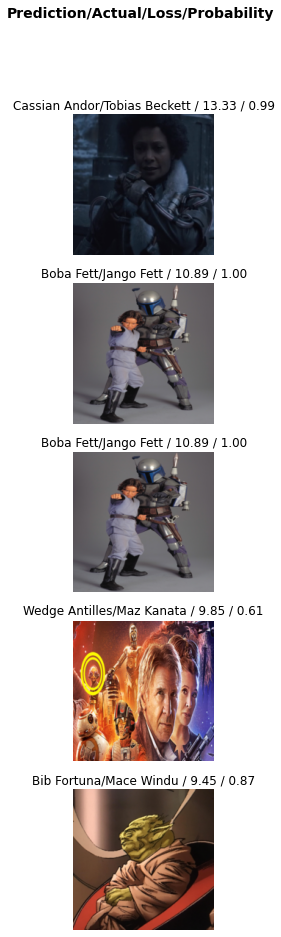

In [25]:
interp.plot_top_losses(5, nrows=5)